# Cold Diffusion

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
import copy
import math

from tqdm.notebook import trange, tqdm

In [2]:
# training parameters
batch_size = 4
lr = 1e-4

train_epoch = 10

# data_loader
img_size = 16

data_set_root = "../datasets"

<b> Use a GPU if avaliable </b>

In [3]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [4]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=([0.5]), std=([0.5]))
                                ])

trainset = datasets.KMNIST(data_set_root, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 18.2M/18.2M [00:16<00:00, 1.09MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.36MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 3.95MB/s]


In [5]:
class ConditionalNorm2d(nn.Module):
    def __init__(self, channels, num_features, norm_type="gn"):
        super(ConditionalNorm2d, self).__init__()
        self.channels = channels
        if norm_type == "bn":
            self.norm = nn.BatchNorm2d(channels, affine=False, eps=1e-4)
        elif norm_type == "gn":
            self.norm = nn.GroupNorm(8, channels, affine=False, eps=1e-4)
        else:
            raise ValueError("Normalisation type not recognised.")

        self.fcw = nn.Linear(num_features, channels)
        self.fcb = nn.Linear(num_features, channels)

    def forward(self, x, features):
        out = self.norm(x)
        w = self.fcw(features)
        b = self.fcb(features)

        out = w.view(-1, self.channels, 1, 1) * out + b.view(-1, self.channels, 1, 1)
        return out


class ResDown(nn.Module):
    """
    Residual down sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=64):
        super(ResDown, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_out, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size, 1, kernel_size // 2)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.act_fnc(self.norm1(x, features))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResUp(nn.Module):
    """
    Residual up sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2, num_features=128):
        super(ResUp, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.up_nn(self.act_fnc(self.norm1(x, features)))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResBlock(nn.Module):
    """
    Residual block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=128):
        super(ResBlock, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        if not channel_in == channel_out:
            self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        else:
            self.conv3 = None

        self.act_fnc = nn.ELU()

    def forward(self, x_in, features):
        x = self.act_fnc(self.norm1(x_in, features))

        if self.conv3 is not None:
            skip = self.conv3(x)
        else:
            skip = x_in

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class Encoder(nn.Module):
    """
    Encoder block
    """

    def __init__(self, channels, ch=32, blocks=(1, 2, 4), num_features=64):
        super(Encoder, self).__init__()
        self.conv_in = nn.Conv2d(channels, blocks[0] * ch, 3, 1, 1)

        widths_in = list(blocks)
        widths_out = list(blocks[1:]) + [blocks[-1]]

        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResDown(w_in * ch, w_out * ch, num_features=num_features))

        self.block_out = ResBlock(w_out * ch, w_out * ch, num_features=num_features)

        self.act_fnc = nn.ELU()

    def forward(self, x, index_features):
        x = self.conv_in(x)
        skip_list = [x]

        for block in self.layer_blocks:
            x = block(x, index_features)
            skip_list.append(x)
        
        x = self.block_out(x, index_features)
        return x, skip_list


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=32, blocks=(1, 2, 4), num_features=64):
        super(Decoder, self).__init__()
        
        widths_out = list(blocks)[::-1]
        widths_in = (list(blocks[1:]) + [blocks[-1]])[::-1]

        self.block_in = ResBlock(blocks[-1] * ch, blocks[-1] * ch, num_features=num_features)
        
        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResUp(w_in * ch * 2, w_out * ch, num_features=num_features))

        self.conv_out = nn.Conv2d(blocks[0] * ch * 2, channels, 3, 1, 1)
        self.act_fnc = nn.ELU()

    def forward(self, x_in, skip_list, index_features):
        x = self.block_in(x_in, index_features)
        
        for block in self.layer_blocks:
            skip = skip_list.pop()
            x = torch.cat((x, skip), 1)
            x = block(x, index_features)
            
        skip = skip_list.pop()
        x = torch.cat((x, skip), 1)
        return self.conv_out(x)

    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Unet(nn.Module):
    """
    Unet network, uses the above encoder and decoder blocks
    """
    def __init__(self, channel_in=3, ch=32, blocks=(1, 2, 4), timesteps=10, num_features=64):
        super(Unet, self).__init__()        
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(num_features),
            nn.Linear(num_features, 2 * num_features),
            nn.GELU(),
            nn.Linear(2 * num_features, num_features),
            nn.GELU()
        )
        
        self.encoder = Encoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)
        self.decoder = Decoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)

    def forward(self, x, index):
        index_features = self.time_mlp(index)
        
        bottleneck, skip_list = self.encoder(x, index_features)
        recon_img = self.decoder(bottleneck, skip_list, index_features)
        return recon_img


## Cosine schedual

In [6]:
def cosine_alphas_bar(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, steps, steps)
    alphas_bar = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    return alphas_bar[:timesteps]

## Reverse Cold Diffusion Process 
We're implementing DDIM, specifically cold diffusion, which can use any transformation, however we are just doing de-noising.

[Cold Diffusion](https://arxiv.org/pdf/2208.09392.pdf)

In [7]:
def noise_from_x0(curr_img, img_pred, alpha):
    return (curr_img - alpha.sqrt() * img_pred)/((1 - alpha).sqrt() + 1e-4)

In [8]:
def cold_diffuse(diffusion_model, sample_in, total_steps):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    with torch.no_grad():
        for i in trange(total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise

            random_sample += rep2 - rep1

        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output


In [9]:
# Create a dataloader itterable object
dataiter = iter(train_loader)
# Sample from the itterable object
images, labels = next(dataiter)

In [10]:
timesteps = 8  # number of interpolation steps

# network
u_net = Unet(channel_in=images.shape[1], ch=32, blocks=(1, 2, 4), timesteps=timesteps).to(device)

#A fixed latent noise vector so we can see the improvement over the epochs
fixed_latent_noise = torch.randn(images.shape[0], images.shape[1], img_size, img_size).to(device)

# Adam optimizer
optimizer = optim.Adam(u_net.parameters(), lr=lr)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epoch, eta_min=0)

In [11]:
loss_log = []
mean_loss = 0

alphas = torch.flip(cosine_alphas_bar(timesteps), (0,)).to(device)

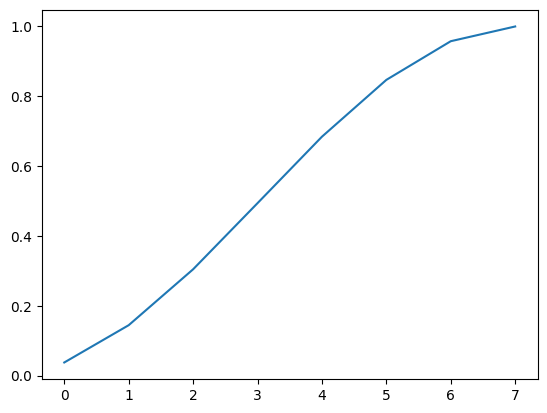

In [12]:
_ = plt.plot(alphas.cpu())

In [13]:
alpha_batch = alphas.reshape(-1, 1, 1, 1)
images_1 = images[0:1].expand(alpha_batch.shape[0], images.shape[1], img_size, img_size).to(device)
latent_noise = torch.randn_like(images_1)
noise_input = alpha_batch.sqrt() * images_1 + (1 - alpha_batch).sqrt() * latent_noise

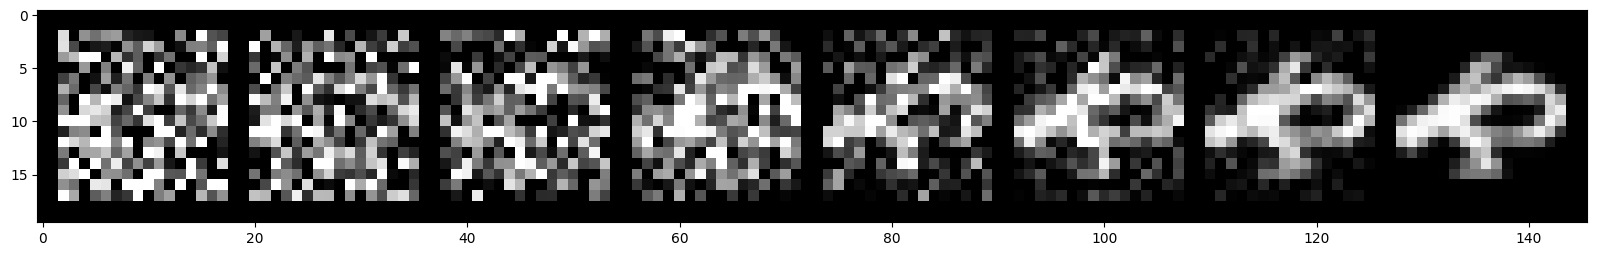

In [14]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(torch.clamp(noise_input, -1, 1).cpu(), 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [15]:
bs = images.shape[0]
images = images.to(device)

rand_index = torch.randint(timesteps, (bs, ), device=device)
alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)
noise_input = alpha_batch.sqrt() * images + (1 - alpha_batch).sqrt() * fixed_latent_noise

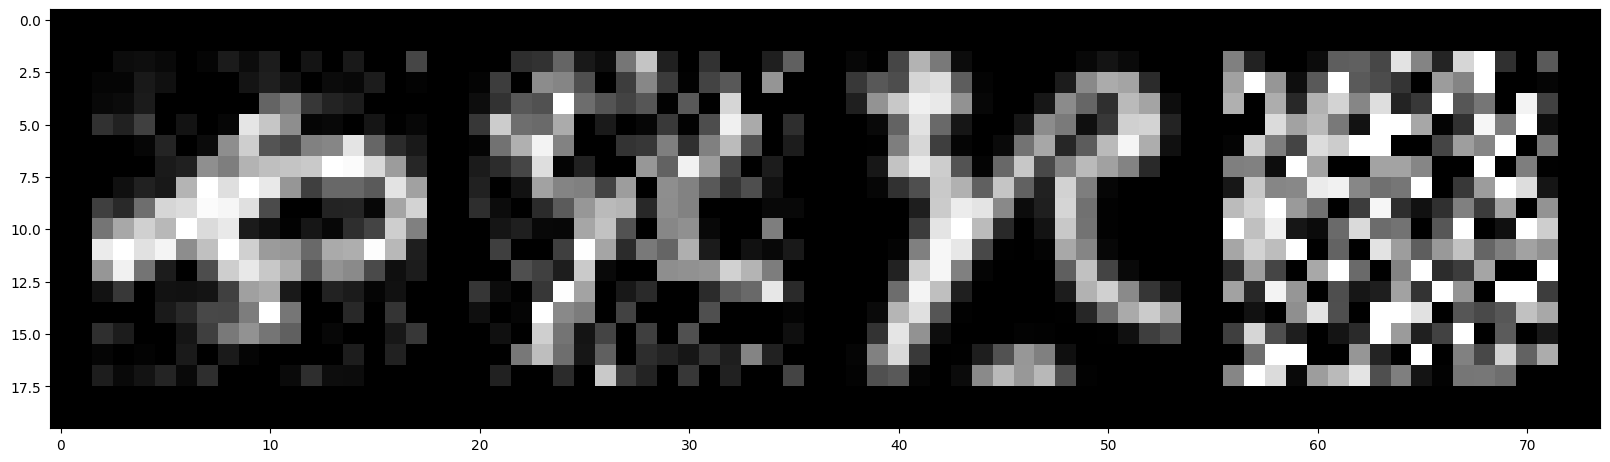

In [16]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(torch.clamp(noise_input, -1, 1)[:16].cpu(), 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
pbar = trange(train_epoch, leave=False, desc="Epoch")    
u_net.train()
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (mean_loss/len(train_loader)))
    mean_loss = 0

    for num_iter, (images, labels) in enumerate(tqdm(train_loader, leave=False)):

        images = images.to(device)
        
        #the size of the current minibatch
        bs = images.shape[0]

        rand_index = torch.randint(timesteps, (bs, ), device=device)
        random_sample = torch.randn_like(images)
        alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)
        
        noise_input = alpha_batch.sqrt() * images + (1 - alpha_batch).sqrt() * random_sample

        img_pred = u_net(noise_input, rand_index)
        
        loss = F.l1_loss(img_pred, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #log the generator training loss
        loss_log.append(loss.item())
        mean_loss += loss.item()
        
    lr_schedule.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(torch.clamp(noise_input, -1, 1).detach().cpu(), nrow=16, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(img_pred.detach().cpu(), nrow=16, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
plt.plot(loss_log)

In [ ]:
fake_sample = cold_diffuse(u_net, fixed_latent_noise, total_steps=timesteps)

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(fake_sample.detach().cpu(), nrow=16, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))